In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as mno

In [2]:
clevelandData = pd.read_csv("processed.cleveland.data", sep =",", header= None, na_values=["?"])
switzerlandData = pd.read_csv("processed.switzerland.data", sep= ",", header= None, na_values=["?"])
longbeachData = pd.read_csv("processed.va.data", sep = "," , header=None, na_values=["?"])
hungarianData = pd.read_csv("reprocessed.hungarian.data", sep = " " , header=None, na_values=["?"])
data = pd.concat([clevelandData, switzerlandData, longbeachData, hungarianData])
data.columns = ["age", "sex", "cp", "trestbps", "chol", "fbs" , "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "prediction"]

<Axes: >

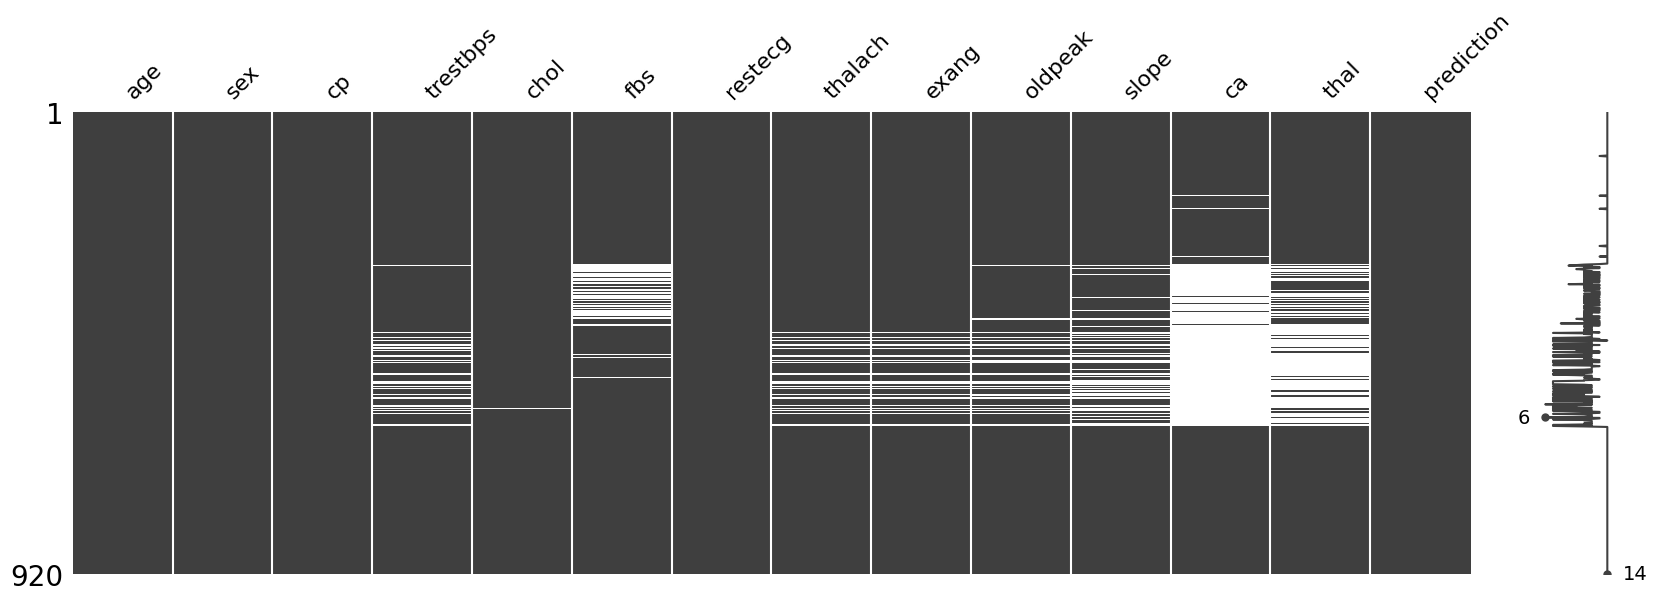

In [3]:
data = data.dropna(axis= 0, subset=["prediction"])
data.isnull().sum()/len(data)
mno.matrix(data, figsize=(20,6))

<Axes: >

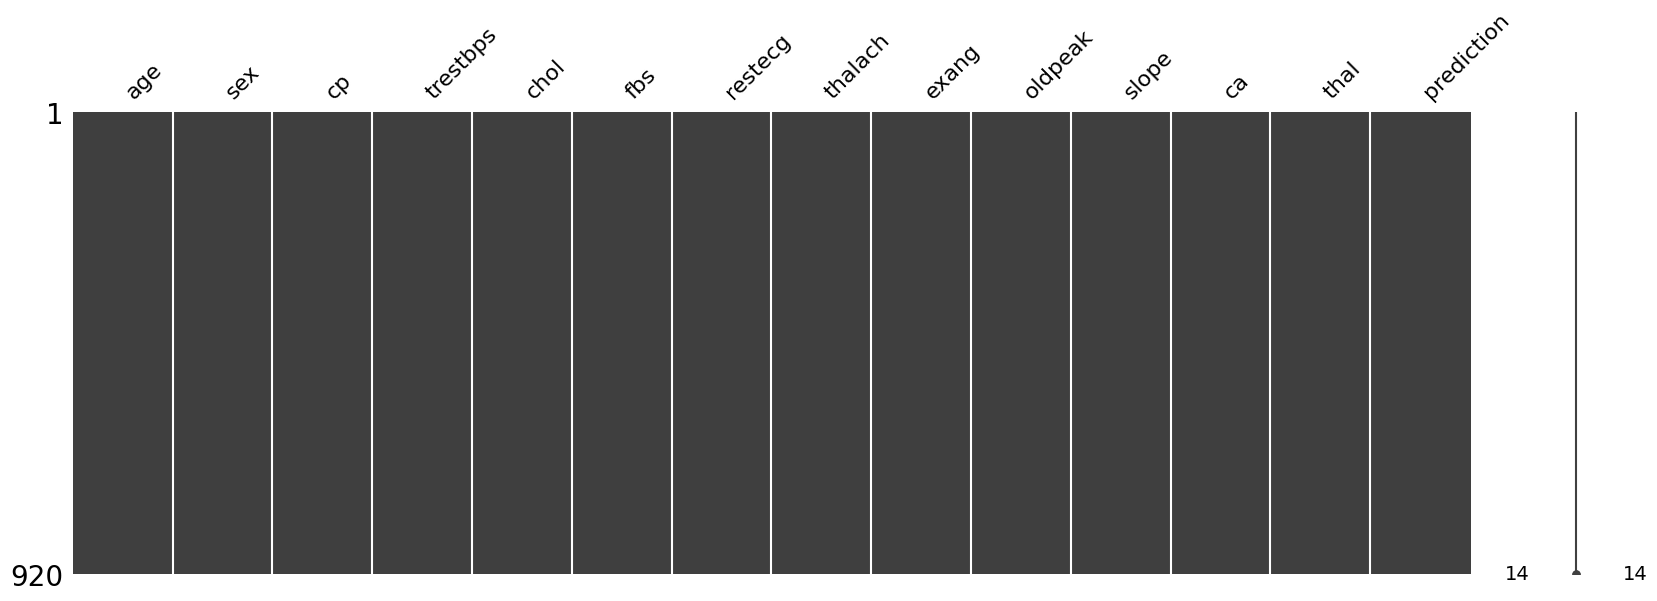

In [11]:
nanImpute =IterativeImputer (random_state= 0)
dataval = nanImpute.fit_transform(data)

data = pd.DataFrame(dataval, columns=  ["age", "sex", "cp", "trestbps", "chol", "fbs" , "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "prediction"])